# SQL via Python: NYC School Data Exploration

Objectives:

In this notebook I will use Python and SQL together to explore real-world education data. I will connect to a PostgreSQL database, write SQL queries and analyze school-level insights. 

The following topics/tasks will be covered:

1. School distribution:
   - How many schools are there in each borough?
2. Language Learners:
   - What is the average % of Englisch Language Learners (ELL) per borough?
3. Schools supporting special needs:
   - What are the Top-3 schools with the highest percentage of special education students (`spec_percent`) in each borough?

The questions will be answered by using SQL, the results will be stored in dataframes.


## 1. Import libraries and connection to database

In [2]:
# General libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import psycopg2
from sqlalchemy import create_engine
from sqlalchemy import inspect

In [3]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [5]:
# DB connection setup using hardcoded credentials
conn = psycopg2.connect(
    dbname="neondb",
    user="neondb_owner",
    password="npg_CeS9fJg2azZD",
    host="ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech",
    port="5432",
    sslmode="require"
)
cur = conn.cursor()

OperationalError: connection to server at "ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech" (2600:1f16:12b2:b40a:533d:22ad:38c2:f393), port 5432 failed: ERROR:  password authentication failed for user 'neondb_owner'


In [6]:
query_test = "SELECT * FROM nyc_schools.high_school_directory LIMIT 5;"
df = pd.read_sql(query_test, conn)
df.head()

NameError: name 'conn' is not defined

In [94]:
query_all_tables = """
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema NOT IN ('information_schema', 'pg_catalog')
ORDER BY table_schema, table_name;
"""
df_all_tables = pd.read_sql(query_all_tables, conn)
df_all_tables

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_2906/1204715339.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all_tables = pd.read_sql(query_all_tables, conn)


,table_schema,table_name
0,dependency_example,banks_test_kovalivska_aws
1,dependency_example,departments
2,dependency_example,districts
3,dependency_example,employees
4,dependency_example,martin_svitek_sat_results
5,dependency_example,neighborhoods
6,nyc_schools,anastasia_sat_results
7,nyc_schools,cleaned_sat_results
8,nyc_schools,hakim-murphy_sat_results
9,nyc_schools,heike_reichert_sat_results


In [4]:
query_columns_and_types1 = """
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'nyc_schools'
  AND table_name = 'high_school_directory'
ORDER BY column_name;
"""

pd.set_option("display.max_rows", None)

df_columns_and_types1 = pd.read_sql(query_columns_and_types1, conn)
df_columns_and_types1

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_74759/1341483714.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_columns_and_types1 = pd.read_sql(query_columns_and_types1, conn)


,column_name,data_type
0,Borough Boundaries,character varying
1,Census Tract,character varying
2,City Council Districts,character varying
3,Community Board,character varying
4,Community Districts,character varying
5,Council District,character varying
6,Location 1,character varying
7,Police Precincts,character varying
8,Zip Codes,character varying
9,addtl_info1,character varying


In [96]:
query_columns_and_types2 = """
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'nyc_schools'
  AND table_name = 'school_demographics'
ORDER BY column_name;
"""

pd.set_option("display.max_rows", None)

df_columns_and_types2 = pd.read_sql(query_columns_and_types2, conn)
df_columns_and_types2

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_2906/63233348.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_columns_and_types2 = pd.read_sql(query_columns_and_types2, conn)


,column_name,data_type
0,Name,character varying
1,asian_num,integer
2,asian_per,real
3,black_num,integer
4,black_per,real
5,ctt_num,integer
6,dbn,character varying
7,ell_num,integer
8,ell_percent,real
9,female_num,integer


## 2. Objectives

### 1. How many schools are there in each borough?

In [5]:
query_n_schools = """
SELECT borough, COUNT(DISTINCT dbn) AS school_count
FROM nyc_schools.high_school_directory
GROUP BY borough;
"""
df_result1 = pd.read_sql(query_n_schools, conn)
df_result1

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_74759/200674138.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_result1 = pd.read_sql(query_n_schools, conn)


,borough,school_count
0,Bronx,118
1,Brooklyn,121
2,Manhattan,106
3,Queens,80
4,Staten Island,10


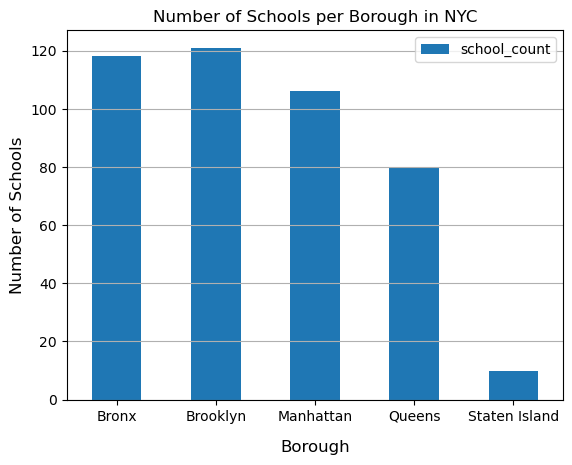

In [6]:
df_result1.plot(x="borough", y="school_count", kind="bar")
plt.xlabel("Borough", fontsize=12, labelpad=12)
plt.ylabel("Number of Schools", fontsize=12)
plt.title("Number of Schools per Borough in NYC")
plt.grid(axis="y")
plt.xticks(rotation=0)
plt.show()

### 2. What is the average % of Englisch Language Learners (ELL) per borough?

In [99]:
query_left_direct = """
SELECT
  d.borough,
  COUNT(sd.dbn) AS matched_schools,
  ROUND(AVG(CAST(sd.ell_percent AS NUMERIC)), 2) AS avg_ell_percent_direct
FROM nyc_schools.high_school_directory d
LEFT JOIN nyc_schools.school_demographics sd
  ON TRIM(UPPER(d.dbn)) = TRIM(UPPER(sd.dbn))
GROUP BY d.borough
ORDER BY d.borough;
"""

df_query_left_direct = pd.read_sql(query_left_direct, conn).set_index("borough")
df_query_left_direct

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_2906/660341840.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_query_left_direct = pd.read_sql(query_left_direct, conn).set_index("borough")


,matched_schools,avg_ell_percent_direct
borough,,
Bronx,0,NaN
Brooklyn,0,NaN
Manhattan,40,7.57
Queens,0,NaN
Staten Island,0,NaN


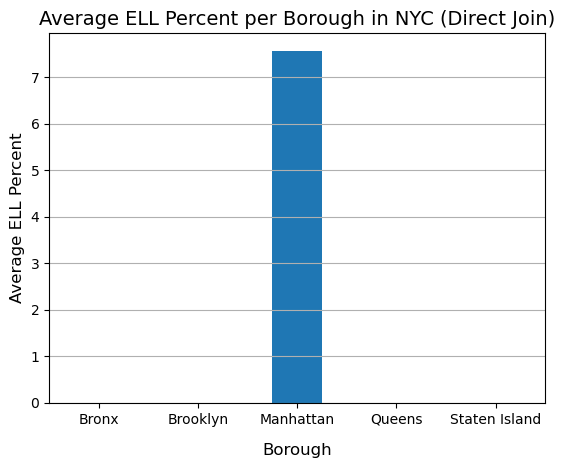

In [100]:
df_query_left_direct.plot(kind="bar", y="avg_ell_percent_direct", legend=False)
plt.xlabel("Borough", fontsize=12, labelpad=12)
plt.ylabel("Average ELL Percent", fontsize=12)
plt.title("Average ELL Percent per Borough in NYC (Direct Join)", fontsize=14)
plt.grid(axis="y")
plt.xticks(rotation=0)
plt.show()

### 3. What are the Top-3 schools with the highest percentage of special education students (`sped_percent`) in each borough?

In [1]:
query_top3_sped_per_borough = """
WITH ranked AS (
  SELECT
    d.borough,
    d.school_name,
    sd.sped_percent,
    ROW_NUMBER() OVER (
      PARTITION BY d.borough
      ORDER BY sd.sped_percent DESC NULLS LAST
    ) AS rn
  FROM nyc_schools.school_demographics sd
  JOIN nyc_schools.high_school_directory d
    ON TRIM(UPPER(sd.dbn)) = TRIM(UPPER(d.dbn))
)
SELECT
  borough,
  school_name,
  ROUND(sped_percent::numeric, 2) AS sped_percent
FROM ranked
WHERE rn <= 3
ORDER BY borough, rn;
"""
df_top3_sped_per_borough = pd.read_sql(query_top3_sped_per_borough, conn)
df_top3_sped_per_borough

NameError: name 'pd' is not defined

## 3. Insights

### 1. Number of Schools per Borough
| Borough       | School Count |
|---------------|--------------|
| Brooklyn      | 121          |
| Queens        | 80           |
| Staten Island | 10           |
| Manhattan     | 106          |
| Bronx         | 118          |

➡️ **Brooklyn** and the **Bronx** have the largest number of schools in the dataset, while **Staten Island** has the fewest.

---

### 2. Percentage of English Language Learners (ELL) per Borough
| Borough       | Matched Schools | Avg. % ELL |
|---------------|-----------------|------------|
| Bronx         | 0               | –          |
| Brooklyn      | 0               | –          |
| Manhattan     | 40              | 7.57 %     |
| Queens        | 0               | –          |
| Staten Island | 0               | –          |

➡️ Only **Manhattan** currently has demographic data available.  
The average share of **ELL students in Manhattan is ~7.6%**.  
For all other boroughs, data is missing.

---

### 3. Top-3 Schools with Highest % of Special Education Students
| Borough   | School Name                                         | % Special Ed |
|-----------|-----------------------------------------------------|--------------|
| Manhattan | East Side Community School                          | 26.4 %       |
| Manhattan | Marta Valle High School                             | 25.9 %       |
| Manhattan | Henry Street School for International Studies       | 24.9 %       |

➡️ All three schools are located in **Manhattan**, which is consistent with the fact that special education data is only available there.

---

### Conclusion
- The dataset is currently **incomplete**: demographic records exist only for Manhattan.  
- The **ELL analysis** therefore provides results only for Manhattan.  
- The **Special Education Top-3** list also reflects Manhattan schools exclusively.  
- To enable a full borough-level analysis, the missing demographic data needs to be added.